## Our Model
Here we will be creating different models to classify our data. 

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set configurations
pd.set_option('display.max_columns', 100)
sns.set_style("white")

# model imports
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import pickle
import joblib

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
import wordninja

In [2]:
model_data = pd.read_csv('../data/data_for_model.csv', keep_default_na=False)

In [3]:
model_data.head(3)

,title,selftext,author,num_comments,is_suicide,url,selftext_clean,title_clean,author_clean,selftext_length,title_length,megatext_clean
0,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...,SQLwitch,133,0,https://www.reddit.com/r/depression/comments/d...,understand people reply immediately op invitat...,broken least understood rule helper may invite...,sql witch,4792,144,sql witch understand people reply immediately ...
1,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...,circinia,1644,0,https://www.reddit.com/r/depression/comments/e...,welcome r depression check post place take mom...,regular check post,c irc,650,21,c irc welcome r depression check post place ta...
2,I hate it so much when you try and express you...,I've been feeling really depressed and lonely ...,TheNewKiller69,8,0,https://www.reddit.com/r/depression/comments/f...,feeling really depressed lonely lately job ful...,hate much try express feeling parent turn arou...,new killer 69,1866,137,new killer 69 feeling really depressed lonely ...


In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1897 non-null   object
 1   selftext         1897 non-null   object
 2   author           1897 non-null   object
 3   num_comments     1897 non-null   int64 
 4   is_suicide       1897 non-null   int64 
 5   url              1897 non-null   object
 6   selftext_clean   1897 non-null   object
 7   title_clean      1897 non-null   object
 8   author_clean     1897 non-null   object
 9   selftext_length  1897 non-null   int64 
 10  title_length     1897 non-null   int64 
 11  megatext_clean   1897 non-null   object
dtypes: int64(4), object(8)
memory usage: 178.0+ KB


Establishing a baseline accuracy is important for evaluating the model's progression. If every prediction was 1, let's see what our accuracy would be.

In [5]:
model_data['is_suicide'].mean()

0.5166051660516605

Our baseline accuracy is about 51.7%

### Selection of Features and Attributes
Here we are attempting to create a model using CountVectorizer and Naive Bayes Model to determine which columns are the best to score and use for our model.

In [6]:
# Creating a function to score different models from different columsn in the dataset

columns_list = ['column_1', "column_2", "column_3"]
model = "CountVec + MultinomialNB"
df_list=[] 

def multi_modelling(columns_list, model):
    for i in columns_list:
        
        X = model_data[i]
        y = model_data['is_suicide']
        
        # train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
        
        cvec = CountVectorizer()
        cvec.fit(X_train)
        
        # creating dataframes
        X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                               columns=cvec.get_feature_names())
        X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                               columns=cvec.get_feature_names())
        
        nb = MultinomialNB()
        nb.fit(X_train,y_train)
        
        # get predictions from model
        pred = nb.predict(X_test)
        
        # create confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
        
        # calculating AUC
        nb.predict_proba(X_test)
        pred_proba = [i[1] for i in nb.predict_proba(X_test)] 
        auc = roc_auc_score(y_test, pred_proba)

        # classification report
        classi_dict = (classification_report(y_test,pred, output_dict=True))

        # storing our results
        model_results = {}
        model_results['series used (X)'] = i
        model_results['model'] = model
        model_results['AUC Score'] = auc
        model_results['precision']= classi_dict['weighted avg']['precision']
        model_results['recall (sensitivity)']= classi_dict['weighted avg']['recall']
        model_results['confusion matrix']={"TP": tp,"FP":fp, "TN": tn, "FN": fn}
        model_results['train accuracy'] = nb.score(X_train, y_train)
        model_results['test accuracy'] = nb.score(X_test, y_test)
        model_results['baseline accuracy']=0.5166
        model_results['specificity']= tn/(tn+fp)  
        model_results['f1-score']= classi_dict['weighted avg']['f1-score']
        #model_results['support']= classi_dict['weighted avg']['support']
        model_results
        df_list.append(model_results) 

    pd.set_option("display.max_colwidth", 50)
    return (pd.DataFrame(df_list)).round(2)

For our initial model, it will be a binary classifier. Once the user gets their classification, they will go to another model that will give them specific support. 

Label Encoding: r/SuicideWatch = 1, r/Depression = 0

TP: model predicts suicide, and it is correct

TN: model predicts depression, and it is correct

FP: model predicts suicide, but it is really depression, not good

FN: model predicts depression, but they really are suicidal, this is the worst, misses an at risk patient

In [7]:
# using the function
columns_list = ['selftext', "author", "title",'selftext_clean', "author_clean", "title_clean", "megatext_clean"]
model = "CountVec + MultinomialNB"
df_list=[]
multi_modelling(columns_list, model)

,series used (X),model,AUC Score,precision,recall (sensitivity),confusion matrix,train accuracy,test accuracy,baseline accuracy,specificity,f1-score
0,selftext,CountVec + MultinomialNB,0.69,0.66,0.66,"{'TP': 161, 'FP': 78, 'TN': 152, 'FN': 84}",0.92,0.66,0.52,0.66,0.66
1,author,CountVec + MultinomialNB,0.57,0.63,0.55,"{'TP': 235, 'FP': 204, 'TN': 26, 'FN': 10}",0.99,0.55,0.52,0.11,0.45
2,title,CountVec + MultinomialNB,0.67,0.62,0.62,"{'TP': 167, 'FP': 104, 'TN': 126, 'FN': 78}",0.85,0.62,0.52,0.55,0.62
3,selftext_clean,CountVec + MultinomialNB,0.69,0.67,0.67,"{'TP': 165, 'FP': 78, 'TN': 152, 'FN': 80}",0.91,0.67,0.52,0.66,0.67
4,author_clean,CountVec + MultinomialNB,0.54,0.51,0.51,"{'TP': 169, 'FP': 155, 'TN': 75, 'FN': 76}",0.95,0.51,0.52,0.33,0.50
5,title_clean,CountVec + MultinomialNB,0.67,0.63,0.62,"{'TP': 178, 'FP': 112, 'TN': 118, 'FN': 67}",0.84,0.62,0.52,0.51,0.62
6,megatext_clean,CountVec + MultinomialNB,0.71,0.67,0.67,"{'TP': 160, 'FP': 71, 'TN': 159, 'FN': 85}",0.95,0.67,0.52,0.69,0.67


Based on our results, using the megatext_clean column will be the best option for our model due its good metrics, such as its AUC value. The false negatives are the highest in our confusion matrix, meaning it is good for the model to learn from. 

### Production Model
We will test a few different models by running some perumatations and recording the data.

In [8]:
# Defining a function that test different models and record parameters

def gridsearch_multi(steps_titles, steps_list, pipe_params):
    
    X = model_data["megatext_clean"]
    y = model_data['is_suicide']
    
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    # build dataframe
    gs_results = pd.DataFrame(columns=['model','AUC Score', 'precision', 'recall (sensitivity)', 
                                       'best_params', 'best score', 'confusion matrix', 
                                       'train_accuracy','test_accuracy','baseline_accuracy',
                                       'specificity', 'f1-score'])

    for i in range(len(steps_list)):
        # define pipeline
        pipe = Pipeline(steps=steps_list[i])

        gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
        gs.fit(X_train, y_train)
        
        # getting predictions from model
        pred = gs.predict(X_test)
        
        # confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
        
        classi_dict = (classification_report(y_test,pred, output_dict=True))
        
        # calculating AUC
        gs.predict_proba(X_test)
        pred_proba = [i[1] for i in gs.predict_proba(X_test)] 
        auc = roc_auc_score(y_test, pred_proba)
        
        # create dataframe columns
        model_results = {}
        model_results['model'] = steps_titles[i]
        model_results['AUC Score'] = auc
        model_results['precision']= classi_dict['weighted avg']['precision']
        model_results['recall (sensitivity)']= classi_dict['weighted avg']['recall']
        model_results['best params'] = gs.best_params_
        model_results['best score'] = gs.best_score_
        model_results['confusion matrix']={"TP": tp,"FP":fp, "TN": tn, "FN": fn}
        model_results['train accuracy'] = gs.score(X_train, y_train)
        model_results['test accuracy'] = gs.score(X_test, y_test)
        model_results['baseline accuracy'] = 0.5166
        
        model_results['specificity']= tn/(tn+fp)  
        model_results['f1-score']= classi_dict['weighted avg']['f1-score']


        # add data
        df_list.append(model_results) 
        pd.set_option("display.max_colwidth", 200)
    return (pd.DataFrame(df_list)).round(2)


In [9]:
# testing function with count vectorizor

df_list=[]

# models
steps_titles = ['cvec+ multi_nb','cvec + ss + knn','cvec + ss + logreg']

# pipelines
steps_list = [ 
    [('cv', CountVectorizer()),('multi_nb', MultinomialNB())],
    [('cv', CountVectorizer()),('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
    [('cv', CountVectorizer()),('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression())]
]

# parameters
pipe_params = [
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]},
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]},
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]}
]   

gridsearch_multi(steps_titles, steps_list, pipe_params)

,model,AUC Score,precision,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,specificity,f1-score
0,cvec+ multi_nb,0.72,0.67,0.67,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 71, 'TN': 159, 'FN': 85}",0.68,0.67,0.52,0.69,0.67
1,cvec + ss + knn,0.60,0.58,0.58,"{'cv__max_df': 0.2, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.60,"{'TP': 144, 'FP': 100, 'TN': 130, 'FN': 101}",0.72,0.58,0.52,0.57,0.58
2,cvec + ss + logreg,0.73,0.69,0.69,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 173, 'FP': 75, 'TN': 155, 'FN': 72}",0.69,0.69,0.52,0.67,0.69


In [10]:
# testing function with TFD Vectorizor

# models
steps_titles = ['tvec + multi_nb','tvec + ss + knn','tvec + ss + logreg']

# pipelines
steps_list = [ 
    [('tv', TfidfVectorizer()),('multi_nb', MultinomialNB())],
    [('tv', TfidfVectorizer()),('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
    [('tv', TfidfVectorizer()),('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression())]
]

# parameters
pipe_params = [
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]},
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]},
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]}
]   

gridsearch_multi(steps_titles, steps_list, pipe_params)

,model,AUC Score,precision,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,specificity,f1-score
0,cvec+ multi_nb,0.72,0.67,0.67,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 71, 'TN': 159, 'FN': 85}",0.68,0.67,0.52,0.69,0.67
1,cvec + ss + knn,0.60,0.58,0.58,"{'cv__max_df': 0.2, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.60,"{'TP': 144, 'FP': 100, 'TN': 130, 'FN': 101}",0.72,0.58,0.52,0.57,0.58
2,cvec + ss + logreg,0.73,0.69,0.69,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 173, 'FP': 75, 'TN': 155, 'FN': 72}",0.69,0.69,0.52,0.67,0.69
3,tvec + multi_nb,0.73,0.68,0.68,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}",0.65,"{'TP': 169, 'FP': 77, 'TN': 153, 'FN': 76}",0.68,0.68,0.52,0.67,0.68
4,tvec + ss + knn,0.56,0.54,0.54,"{'tv__max_df': 0.2, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.60,"{'TP': 146, 'FP': 118, 'TN': 112, 'FN': 99}",0.74,0.54,0.52,0.49,0.54
5,tvec + ss + logreg,0.73,0.67,0.67,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 72, 'TN': 158, 'FN': 85}",0.68,0.67,0.52,0.69,0.67


In [11]:
# testing function with Hashing Vectorizor

# models
steps_titles = ['hvec + multi_nb','hvec + ss + knn','hvec + ss + logreg']

# pipelines
steps_list = [ 
    [('hv', HashingVectorizer(alternate_sign=False)),('multi_nb', MultinomialNB())],
    [('hv', HashingVectorizer(alternate_sign=False)),('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
    [('hv', HashingVectorizer(alternate_sign=False)),('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression())]
]

# parameters
pipe_params = [
    {'hv__stop_words':['english'], 'hv__ngram_range':[(1,1),(1,2)]},
    {'hv__stop_words':['english'], 'hv__ngram_range':[(1,1),(1,2)]},
    {'hv__stop_words':['english'], 'hv__ngram_range':[(1,1),(1,2)]}
]   

gridsearch_multi(steps_titles, steps_list, pipe_params)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,model,AUC Score,precision,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,specificity,f1-score
0,cvec+ multi_nb,0.72,0.67,0.67,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 71, 'TN': 159, 'FN': 85}",0.68,0.67,0.52,0.69,0.67
1,cvec + ss + knn,0.60,0.58,0.58,"{'cv__max_df': 0.2, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.60,"{'TP': 144, 'FP': 100, 'TN': 130, 'FN': 101}",0.72,0.58,0.52,0.57,0.58
2,cvec + ss + logreg,0.73,0.69,0.69,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 173, 'FP': 75, 'TN': 155, 'FN': 72}",0.69,0.69,0.52,0.67,0.69
3,tvec + multi_nb,0.73,0.68,0.68,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}",0.65,"{'TP': 169, 'FP': 77, 'TN': 153, 'FN': 76}",0.68,0.68,0.52,0.67,0.68
4,tvec + ss + knn,0.56,0.54,0.54,"{'tv__max_df': 0.2, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.60,"{'TP': 146, 'FP': 118, 'TN': 112, 'FN': 99}",0.74,0.54,0.52,0.49,0.54
5,tvec + ss + logreg,0.73,0.67,0.67,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 72, 'TN': 158, 'FN': 85}",0.68,0.67,0.52,0.69,0.67
6,hvec + multi_nb,0.77,0.69,0.68,"{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.72,"{'TP': 148, 'FP': 54, 'TN': 176, 'FN': 97}",0.89,0.68,0.52,0.77,0.68
7,hvec + ss + knn,0.51,0.75,0.52,"{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.52,"{'TP': 245, 'FP': 229, 'TN': 1, 'FN': 0}",0.52,0.52,0.52,0.00,0.36
8,hvec + ss + logreg,0.65,0.62,0.62,"{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.63,"{'TP': 155, 'FP': 90, 'TN': 140, 'FN': 90}",1.00,0.62,0.52,0.61,0.62


After reviewing all the performances, two models stand out. The Hashing Vectorizor and Multinomial Naive Bayes model had much better metrics, along with the TFID Vectorizor and Multinomial Naive Bayes Model. They both have good AUC values and high generalization.

### Tuning Hyperparameters

In [12]:
# using the function for out two narrowed models

# models
steps_titles = ['hvec + multi_nb(tuning)','tvec + multi_nb(tuning)']

# pipelines
steps_list = [ 
    [('hv', HashingVectorizer(alternate_sign=False)),('multi_nb', MultinomialNB())],
    [('tv', TfidfVectorizer()),('multi_nb', MultinomialNB())]
]

# parameters
pipe_params = [
    {'hv__stop_words':['english'], 'hv__ngram_range':[(1,1),(1,2),(1,3)], 'hv__n_features': [50, 150, 300, 500, 800, 1000]},
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2),(1,3)],'tv__max_features': [20, 30, 50, 70, 100],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3, .35,.4]},
]   

gridsearch_multi(steps_titles, steps_list, pipe_params)

,model,AUC Score,precision,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,specificity,f1-score
0,cvec+ multi_nb,0.72,0.67,0.67,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 71, 'TN': 159, 'FN': 85}",0.68,0.67,0.52,0.69,0.67
1,cvec + ss + knn,0.60,0.58,0.58,"{'cv__max_df': 0.2, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.60,"{'TP': 144, 'FP': 100, 'TN': 130, 'FN': 101}",0.72,0.58,0.52,0.57,0.58
2,cvec + ss + logreg,0.73,0.69,0.69,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.65,"{'TP': 173, 'FP': 75, 'TN': 155, 'FN': 72}",0.69,0.69,0.52,0.67,0.69
3,tvec + multi_nb,0.73,0.68,0.68,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}",0.65,"{'TP': 169, 'FP': 77, 'TN': 153, 'FN': 76}",0.68,0.68,0.52,0.67,0.68
4,tvec + ss + knn,0.56,0.54,0.54,"{'tv__max_df': 0.2, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.60,"{'TP': 146, 'FP': 118, 'TN': 112, 'FN': 99}",0.74,0.54,0.52,0.49,0.54
5,tvec + ss + logreg,0.73,0.67,0.67,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}",0.65,"{'TP': 160, 'FP': 72, 'TN': 158, 'FN': 85}",0.68,0.67,0.52,0.69,0.67
6,hvec + multi_nb,0.77,0.69,0.68,"{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.72,"{'TP': 148, 'FP': 54, 'TN': 176, 'FN': 97}",0.89,0.68,0.52,0.77,0.68
7,hvec + ss + knn,0.51,0.75,0.52,"{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.52,"{'TP': 245, 'FP': 229, 'TN': 1, 'FN': 0}",0.52,0.52,0.52,0.00,0.36
8,hvec + ss + logreg,0.65,0.62,0.62,"{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.63,"{'TP': 155, 'FP': 90, 'TN': 140, 'FN': 90}",1.00,0.62,0.52,0.61,0.62
9,hvec + multi_nb(tuning),0.75,0.68,0.68,"{'hv__n_features': 1000, 'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}",0.69,"{'TP': 170, 'FP': 75, 'TN': 155, 'FN': 75}",0.82,0.68,0.52,0.67,0.68


### TF-IDF Vectorizor + Multinomial Naive Bayes
This model has the best metrics and will work the best for our data. While it isn't the higher AUC, it generalizes better and has higher True Positives. 

## Running our Optimized Model
This model is a combination of TF-IDF("Term Frequency - Inverse Document" Frequency) Vectorizer and the Multinomial Naive Bayes. It assigns scores for the top 70 words in our selected feature. TF-IDF will penalize common words, helping the model find specific key words. The model makes a prediction based on a matrix of word scores and gives a probability of falling into a certain classification. 

In [21]:
# Checking scores of optimized model using test data

X = model_data["megatext_clean"]
y = model_data['is_suicide']
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

tvec_optimised = TfidfVectorizer(max_df= 0.5, max_features=70, min_df=2, ngram_range=(1, 3),stop_words = 'english')
X_train_tvec = tvec_optimised.fit_transform(X_train).todense()
X_test_tvec = tvec_optimised.transform(X_test).todense()

print(X_train_tvec)

# getting accuracies of the model
nb = MultinomialNB()
nb.fit(X_train_tvec, y_train)
accuracy = nb.score(X_test_tvec, y_test)

# calculating AUC

pred_proba = [i[1] for i in nb.predict_proba(X_test_tvec)] 
auc = roc_auc_score(y_test, pred_proba)

# save model
pickle.dump(nb, open("model.h5", 'wb'))
joblib.dump(nb, "model2.h5")

print("Accuracy: {}\nAUC Score: {}".format(accuracy, auc) )

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.34329862 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.19154645]
 ...
 [0.         0.         0.         ... 0.         0.         0.04899098]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Accuracy: 0.6989473684210527
AUC Score: 0.7548003549245785


### Model Performace
Our Model performed well, having an accuracy of 70% and an AUC score of 75%. There are most likely ways to improve the classifier, and we will continue to train the model. 

In [14]:
# Visualizing Most Common Words
def TF_IDF_most_used_words(category_string, data_series, palette, image_mask):
    # find most common words
    tvec_optimised = TfidfVectorizer(max_df= 0.5, max_features=70, min_df=2, ngram_range=(1, 3),stop_words = 'english')
    tvec_optimised.fit(data_series)
    
    # dataframe of extracted words
    created_df = pd.DataFrame(tvec_optimised.transform(data_series).todense(),
                              columns=tvec_optimised.get_feature_names())
    total_words = created_df.sum(axis=0)
    
    # Top 20 words dataframe
    top_20_words = total_words.sort_values(ascending = False).head(20)
    top_20_words_df = pd.DataFrame(top_20_words, columns = ["count"])
    # plotting
    sns.set_style("white")
    plt.figure(figsize = (15, 8), dpi=300)
    ax = sns.barplot(y= top_20_words_df.index, x="count", data=top_20_words_df, palette = palette)
    
    plt.xlabel("Count", fontsize=9)
    plt.ylabel('Common Words in {}'.format(category_string), fontsize=9)
    plt.yticks(rotation=-5)

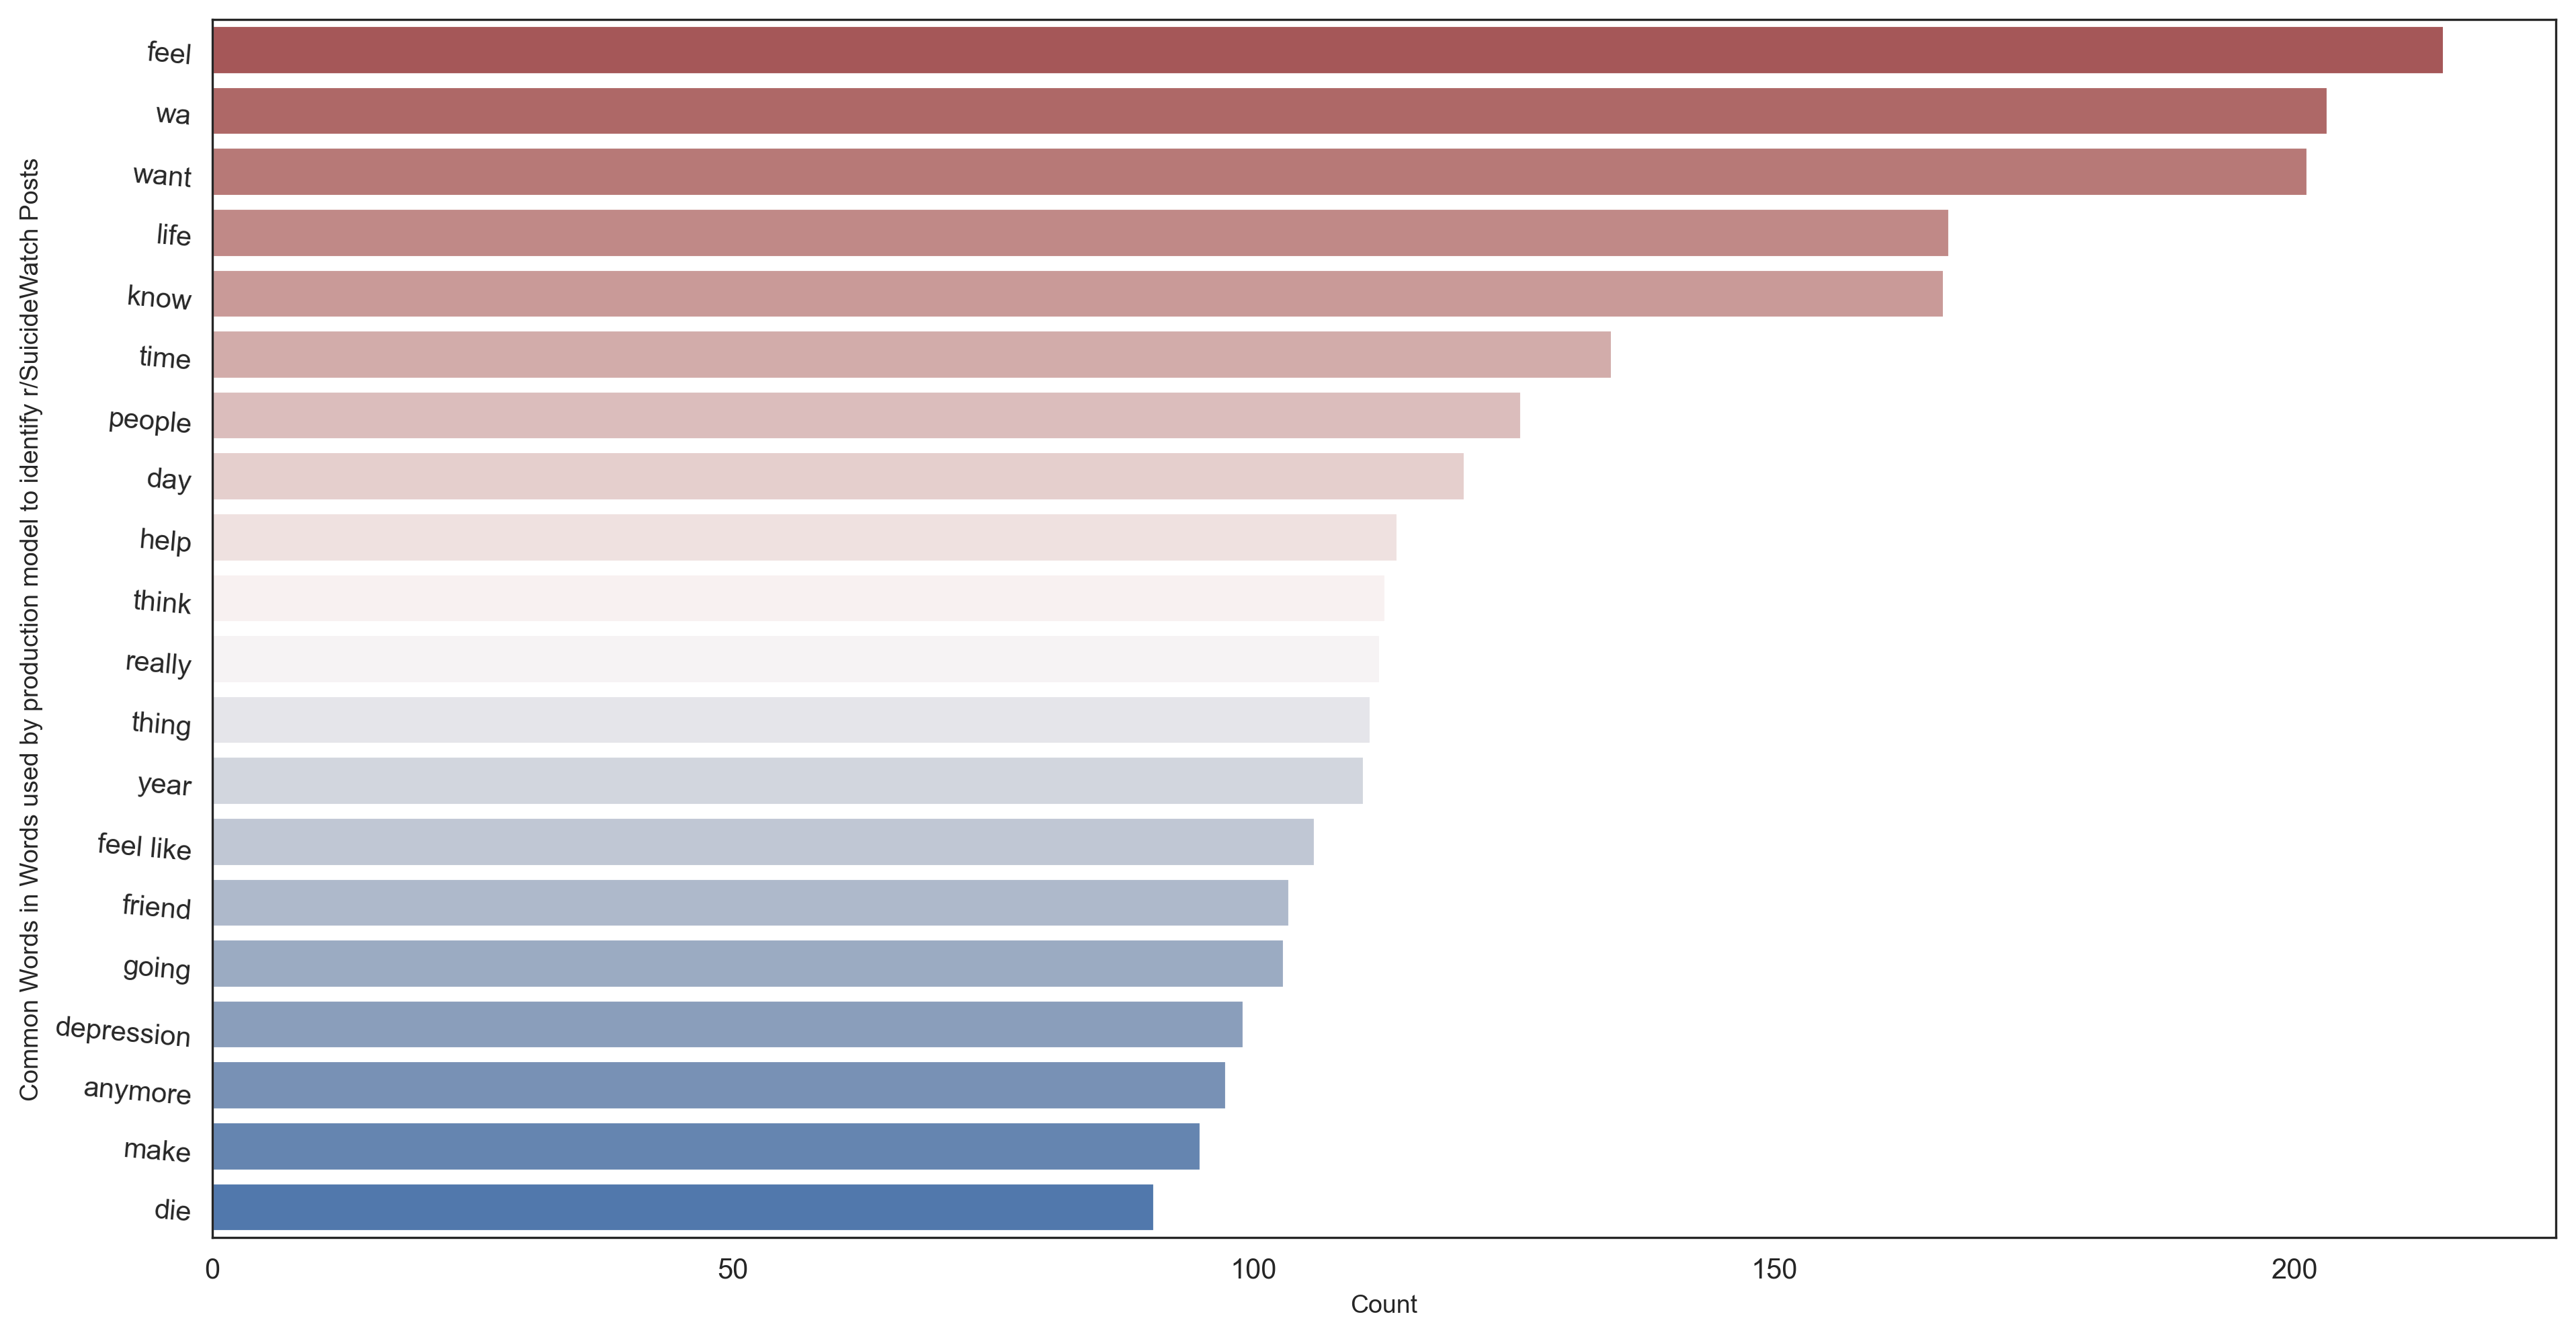

In [15]:
# plotting X_features
TF_IDF_most_used_words("Words used by production model to identify r/SuicideWatch Posts", model_data["megatext_clean"], "vlag_r", image_mask="../assets/ending_mask_8.png")

In [16]:
# finding False Negatives

# creating dataframe
index_seek = list(X_test.index)
fn_explore = model_data.iloc[index_seek, :][["title","selftext","author", "is_suicide"]]
fn_explore["predictions"] = nb.predict(X_test_tvec)

# saving False Negatives
#is_suicide == 1 and predictions == 0
false_negs = fn_explore[fn_explore["is_suicide"]==1][fn_explore["predictions"]==0]
false_negs

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,title,selftext,author,is_suicide,predictions
1862,Ran out of people to turn to,I'm 9 years post the hospitalizations/drug guinea pig era and all the bullshit that comes from not having enough money or insurance to afford professionals that won't prescribe you Jesus or tell y...,throwaway-probly0260,1,0
1628,Pretty sure im gonna,"So like. When I am in a low I crave death. Its gotten rather bad. The lows that is. Its to the point that when I am regular or manic I just casually accept it. \n\nLike ""yeah Im gonna commit. Not ...",Swimmyboiii,1,0
1728,i dont even know what to title this,i think i saw myself in the tub five times this whole day so far and its only 4pm. i care for the people around me very deeply and just the thought of them being devastated when i leave makes me e...,smol-bby,1,0
1053,tired of people saying it will get better when it has constantly been getting worse,fucking liars,J9guy,1,0
1089,I just realized it’s never going to end.,This depression isn’t the temporary kind. I can’t just “wait it out.” I’ll spend the rest of my life with this depression. I can’t survive that. I won’t survive. Guys help.,puriuh,1,0
...,...,...,...,...,...
1177,I miss the physical affection of being in a relationship and it’s making me feel lonely and suicidal,"I don’t know why but, ever since the breakup with my ex 2 months ago, I’ve been feeling more alone, more suicidal. I was by no means not suicidal before the relationship or during the relationship...",zamas2,1,0
1464,i [17f] wish i starved to death a year ago,"a year ago i had really bad anorexia, i lost 50lbs in 2 months and i wish i never stopped. i hate myself so much. i just want to be perfect so bad but i feel like this is how ill live my life now....",cloudysadeyes,1,0
1351,"I just need someone to talk to, man.","2020 is kicking my ass so bad. I got laid off in November, and a pregnancy wouldnt allow me to work until now. I got the call that im going back to work starting Saturday, but whats the use? Unemp...",PeachySneakers,1,0
1112,Please be mindful,When someone is depressed you shouldn’t try to “fix them” you can’t love someone’s depression away but you can love someone through depression when someone all of a sudden is really happy and mayb...,Captain-cookie1,1,0


In [17]:
# Visualizing words for False Negatives
def barplot_most_used_words(category_string, data_series, palette):
    # finding most common words
    tvec_optimised = TfidfVectorizer(max_df= 0.5, max_features=70, min_df=2, ngram_range=(1, 3),stop_words = 'english')
    tvec_optimised.fit(data_series)
    # dataframe 
    created_df = pd.DataFrame(tvec_optimised.transform(data_series).todense(),
                              columns=tvec_optimised.get_feature_names())
    total_words = created_df.sum(axis=0)
    
    top_20_words = total_words.sort_values(ascending = False).head(20)
    top_20_words_df = pd.DataFrame(top_20_words, columns = ["count"])

    # plotting
    sns.set_style("white")
    plt.figure(figsize = (15, 8), dpi=300)
    ax = sns.barplot(y= top_20_words_df.index, x="count", data=top_20_words_df, palette = palette)
    plt.title('\nTop Words used in {}\n'.format(category_string), fontsize=22)
    plt.xlabel("Count", fontsize=9)
    plt.ylabel('Common Words in {}'.format(category_string), fontsize=9)
    plt.yticks(rotation=-5)

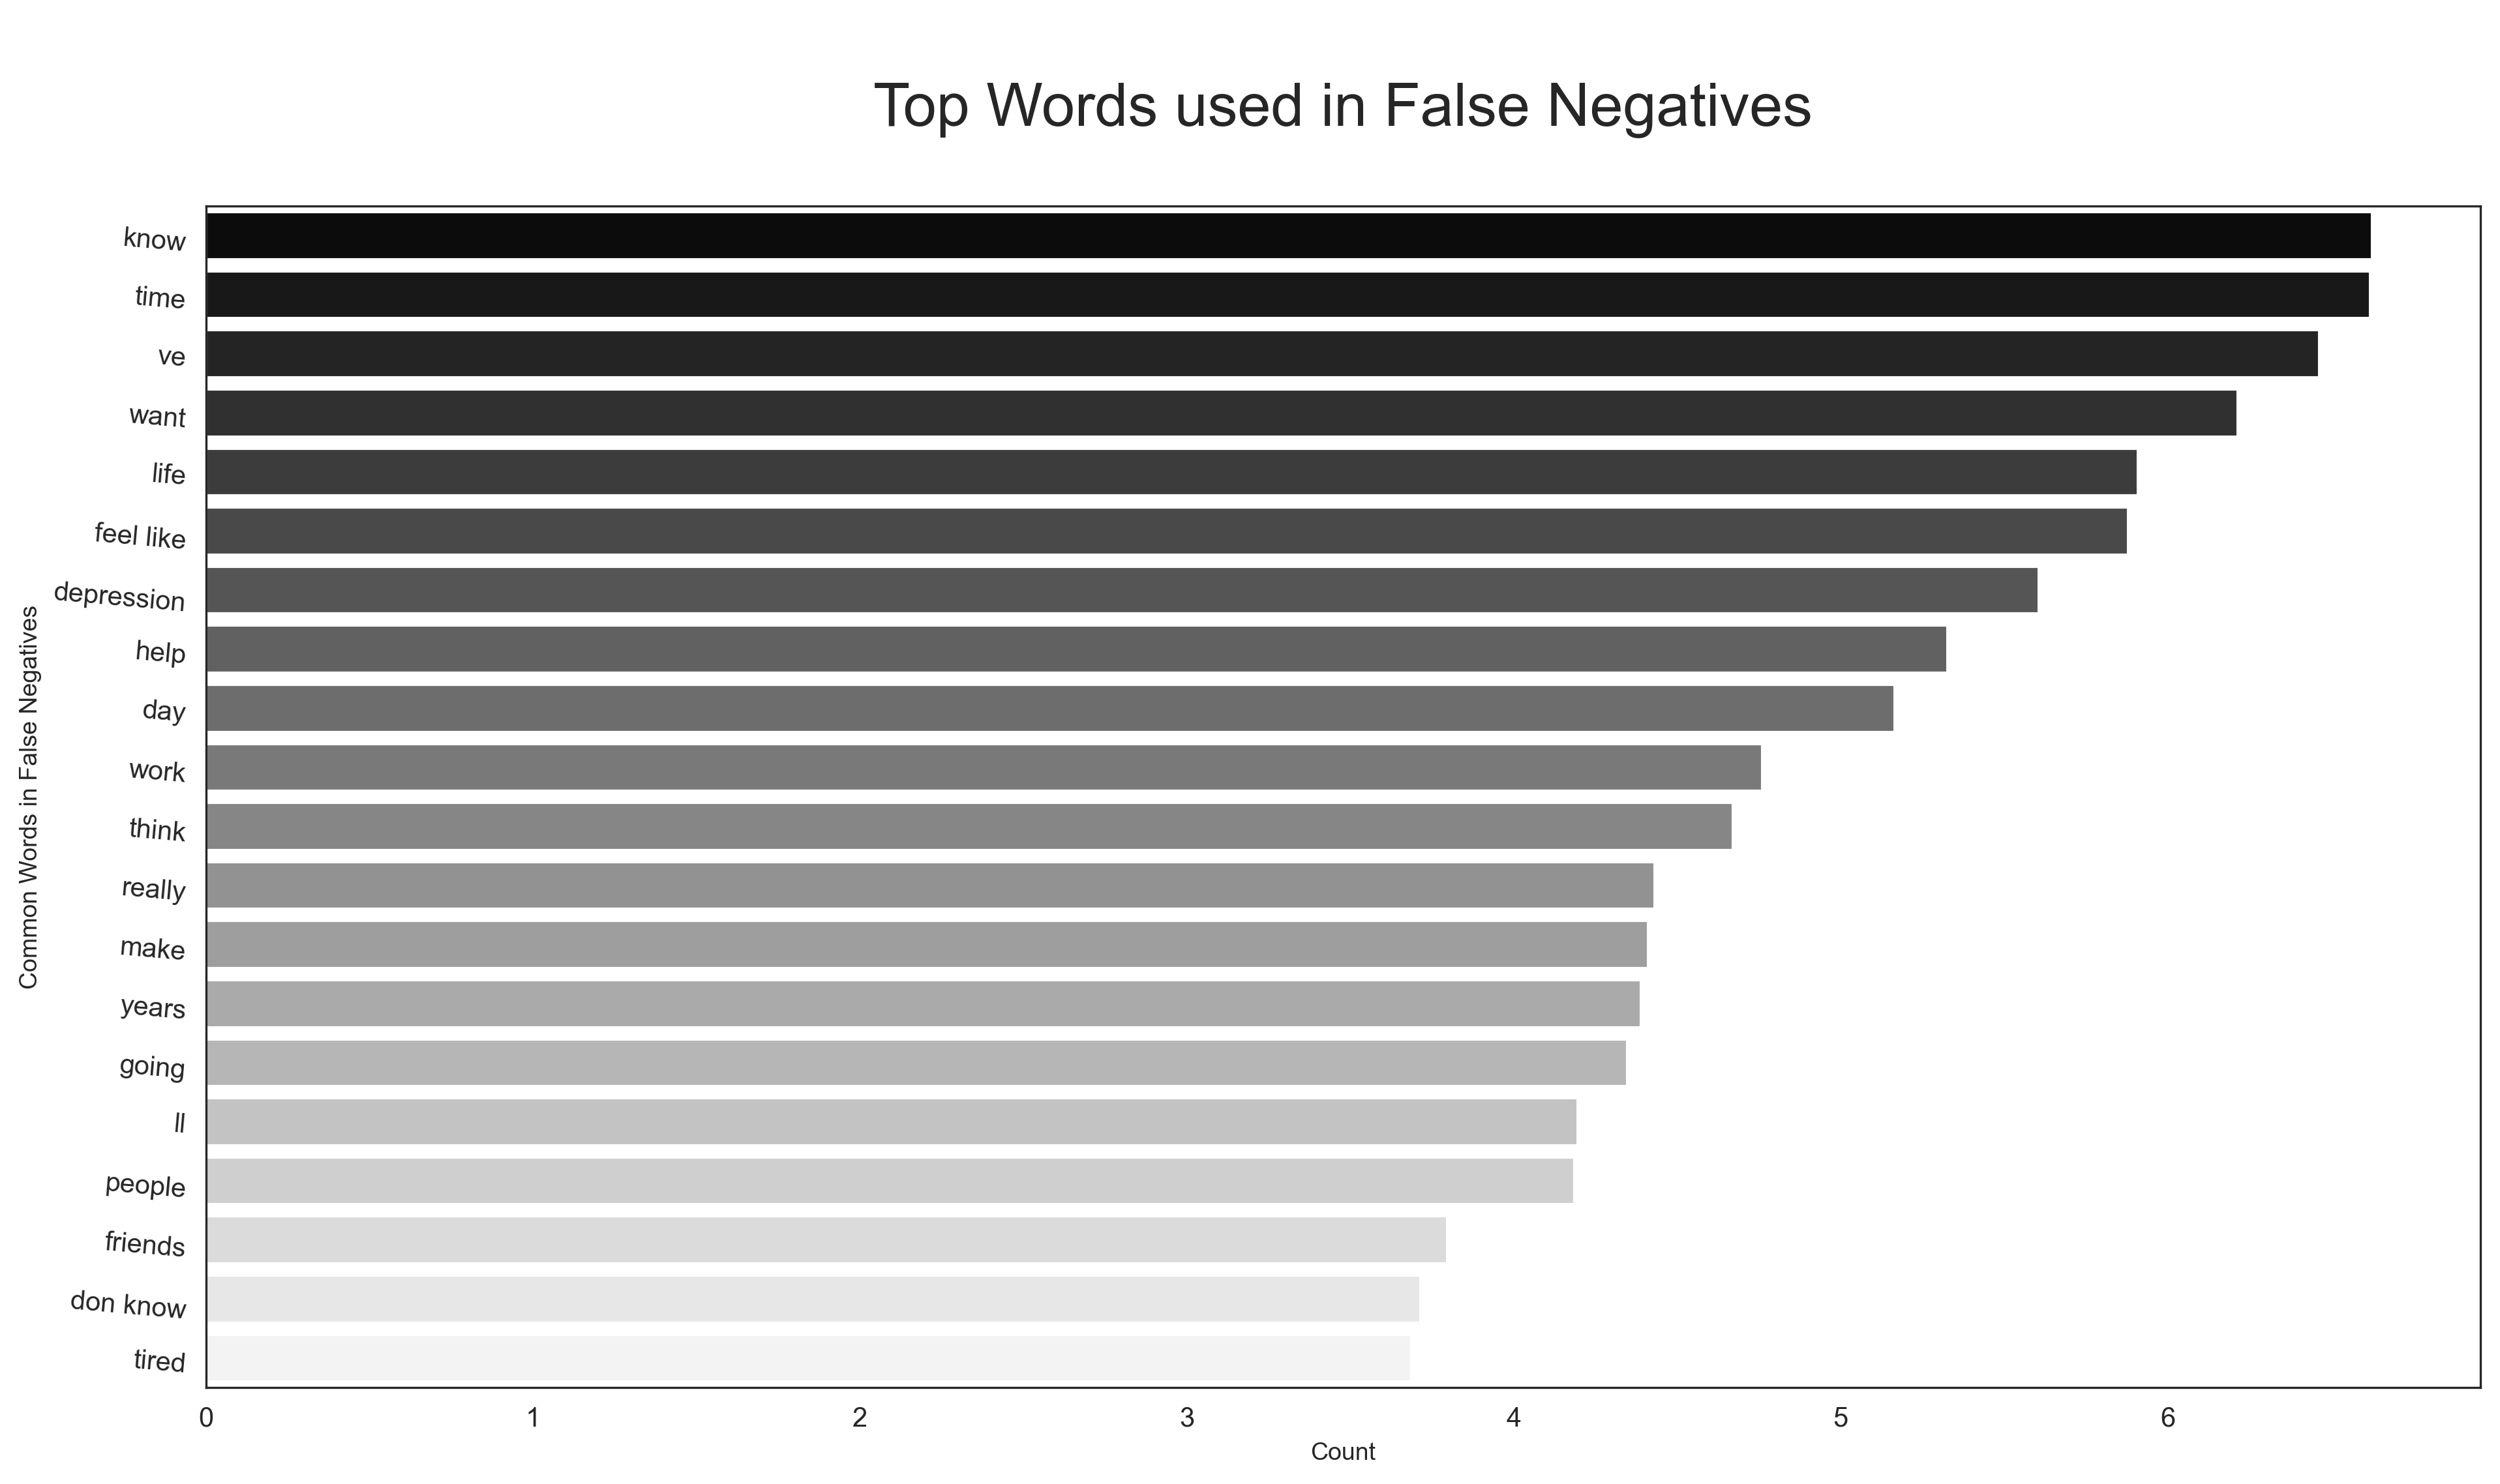

In [18]:
barplot_most_used_words("False Negatives", false_negs["selftext"], "gray")